## **PSI3431 - Processamento Estatístico de Sinais (2022)**
### Exercício Computacional 3 - Densidade Espectral de Potência e Ruído de Quantização


**Aluno:** Ivan Luiz de Moura Matos

**N°USP:** 11234162

**Data de entrega:** 04/06/2022

**<span style="color:red">Ver comentário que adicionei no envio deste arquivo no eDisciplinas.</span>**

<br />

In [1]:
using PyPlot, DSP, WAV, FixedPointNumbers, PyCall, Pkg, Statistics

In [2]:
# Bloco de código necessário para utilizar 
# funções da biblioteca Scipy, do Python.

ENV["PYTHON"] = "";
Pkg.build("PyCall");

pyimport_conda("scipy.signal", "scipy");

sig = pyimport("scipy.signal");

    Building Conda ─→ `C:\Users\Ivan Matos\.julia\scratchspaces\44cfe95a-1eb2-52ea-b672-e2afdf69b78f\6e47d11ea2776bc5627421d59cdcc1296c058071\build.log`
    Building PyCall → `C:\Users\Ivan Matos\.julia\scratchspaces\44cfe95a-1eb2-52ea-b672-e2afdf69b78f\1fc929f47d7c151c839c5fc1375929766fb8edcc\build.log`


## Criação do sinal amostrado $s[n]$ e sua versão quantizada $s_q[n]$

Inicialmente, vamos considerar o sinal de áudio $s(n)$, amostrado com frequência $f_a = 40 \; \textrm{kHz}$, e duração de 3 segundos, dado por:

$$s(t) = 0,5\cdot\cos(2 \pi \cdot f_0 \cdot t) + 
         0,3\cdot\cos(4 \pi \cdot 300 \cdot t) +
         0,15\cdot\cos(6 \pi \cdot f_0 \cdot t)
         $$

O sinal discreto $s[n]$ correspondente é criado a seguir (representado, no código, por ``s``):

In [3]:
# Frequencia de amostragem
fa = 40000;

# Sequencia de instantes em que o sinal x0 foi amostrado:
seq = 0:1/fa:3;

# Criação do sinal s, amostrado com frequencia fa
f0 = 100*pi;
s = 0.5*cos.(2*pi*f0*seq) + 0.3*cos.(4*pi*300*seq) + 0.15*cos.(6*pi*f0*seq);

A seguir, plotamos o gráfico do sinal amostrado $s[n]$, para $0 \leq n \leq 1000$:

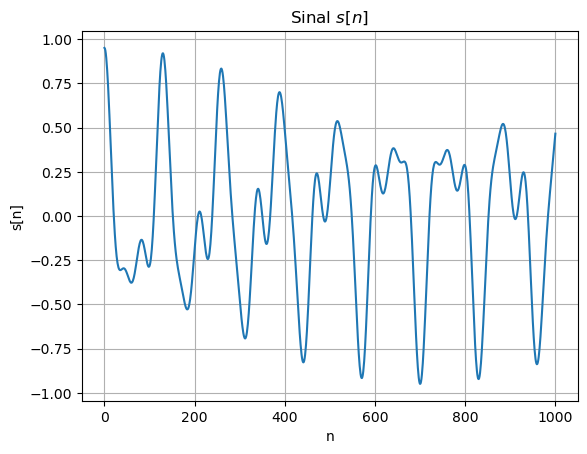

In [4]:
plot(0:1000,s[1:1001]);

title(L"Sinal $s[n]$");
ylabel("s[n]"); xlabel("n"); grid();

A seguir, obtemos a versão quantizada em 5 bits $s_q[n]$ do sinal $s[n]$. Em seguida, plotamos $s_q[n]$ para $0 \leq n \leq 1000$.

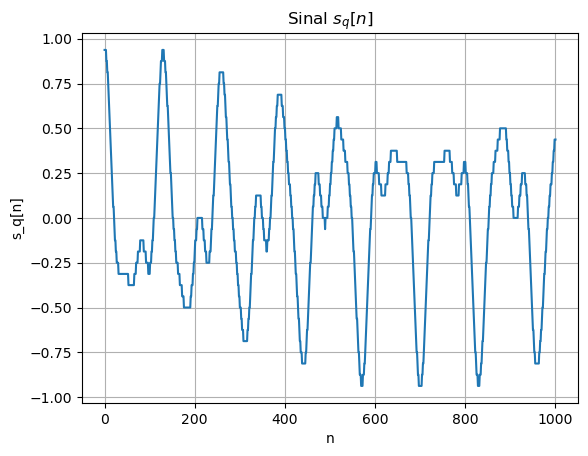

In [5]:
# Criação do sinal quantizado com 5 bits
sq = Fixed{Int16,4}.(s);

plot(0:1000,sq[1:1001]);
title(L"Sinal $s_q[n]$");
ylabel("s_q[n]"); xlabel("n"); grid();

## Cálculo do ruído de quantização e da relação sinal/ruído (SNR)

O ruído de quantização $\varepsilon_0[n]$ do sinal de entrada será definido como $\varepsilon_0[n] = s_q[n] - s[n]$.
No código, denotaremos tal sinal por ``ruido_quant``.
A seguir, plotamos seu gráfico para $0 \leq n \leq 1000$:

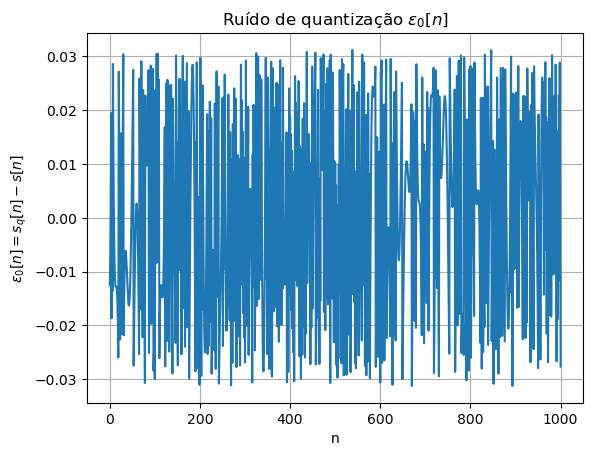

In [6]:
ruido_quant = sq - s;

plot(0:1000,ruido_quant[1:1001]);
title(L"Ruído de quantização $\varepsilon_0[n]$");
ylabel(L"\varepsilon_0[n] = s_q[n]-s[n]"); xlabel("n"); grid();

Podemos aproximar o ruído de quantização como um processo estocástico independente e igualmente distribuído (i.i.d.), com $\varepsilon_0[n] \sim \textrm{Uniforme}(-2^{-B}, 2^{-B})$, em que B é o número de bits utilizados na conversão analógico-digital do sinal $s$ (ou seja, $B = 5$).

Nesse caso, a potência (média) do ruído de quantização, $P_{\varepsilon_0}$, pode ser calculada como sendo igual à sua variância (uma vez que $\varepsilon_0[n]$ é um processo ergódico na correlação, pois é i.i.d. e tem variância finita). Então, **teoricamente**, temos (considerando que a distribuição é uniforme):

$$P_{\varepsilon_0} = \textrm{var}\{\varepsilon_0[n]\} = \frac{[2^{-B} - (-2^{-B})]^2}{12} = \frac{(2\cdot2^{-B})^2}{12} = \frac{(2 \cdot 2^{-5})^2}{12}$$

ou seja: $P_{\varepsilon_0} \approx 3,2552 \cdot 10^{-4} $.

Também podemos calcular a potência média do ruído de quantização como mostrado no trecho de código abaixo, de forma "**experimental**":

In [7]:
pot_ruido_quant = sum(ruido_quant.^2)/length(ruido_quant)

0.00032671071389392344

Notamos que, de fato, o valor teórico da potência média ($3,2552 \cdot 10^{-4}$) é compatível com o valor "experimental" ($3,2671 \cdot 10^{-4}$).

A seguir, calculamos a potência do sinal amostrado $s[n]$:

In [8]:
pot_s = sum(s.^2)/length(s)

0.18124695408240205

Podemos, agora, calcular a relação sinal/ruído (SNR), em dB, dada por:

$$\textrm{SNR (dB)} = 10 \cdot \log_{10} \Big(\frac{\textrm{Potência do sinal $s[n]$}}{\textrm{Potência do ruído de quantização $\varepsilon[n]$}}\Big)$$

Temos, então, o seguinte valor para a SNR (em dB):

In [9]:
SNR_dB = 10*log10(pot_s / pot_ruido_quant)

27.44107340215477

## Projeto do filtro $H_I(z)$

Devemos projetar um filtro IIR $H_I(z)$ utilizando aproximação elíptica. São dadas as seguintes especificações:

- Faixa de passagem: $0 \leq \omega \leq \omega_p$,
- Faixa de rejeição: $0,2\,\pi \; \textrm{rad/amostra} = \omega_r \leq \omega \leq \pi \; \textrm{rad/amostra} $,
- Atenuação mínima na faixa de rejeição: 40 dB ($\Rightarrow \delta_r = 10^{-40/20} = 0,01$),
- Queda máxima na faixa de passagem: $\delta_p = 0,05$.

(Notemos que se trata de um filtro passa-baixas.)

Escolheremos o valor da frequência normalizada $\omega_p$ (que delimita a faixa de passagem do filtro) como sendo igual à **maior** frequência das componentes do sinal $s$. Tomamos, portanto,

$$\omega_p = \frac{6 \pi \cdot f_0}{f_a} = \frac{6 \pi \cdot 100 \pi}{40 \; \textrm{kHz}} \approx 0,1480 \; \textrm{rad/amostra}$$

Do enunciado, a frequência normalizada que delimita a faixa de rejeição é $\omega_r = 0,2\pi \; \textrm{rad/amostra}$.

A partir dessas especificações, podemos projetar o filtro. Usaremos a função ``ellipord`` disponível na biblioteca Scipy do Python, e as funções ``Lowpass``, ``Elliptic``e ``digitalfilter``, disponíveis no pacote DSP da linguagem Julia.

Para obter os coeficientes do numerador e do denominador da função de transferência $H_I(z)$, usaremos respectivamente as funções ``coefb`` e ``coefa`` do pacote DSP. 

In [10]:
omega_p = (6*pi*f0)/fa;

omega_r = 0.2*pi;

delta_p = 0.05;
atenuacao_r = 40; # --> delta_r = 10^(-40/20) = 0.01
delta_r = 10^(-atenuacao_r/20);

N, Wn = sig.ellipord(omega_p/pi, omega_r/pi,-20*log10(1-delta_p), atenuacao_r);

tipo_resposta = Lowpass(Wn);
metodo_projeto = Elliptic(N, -20*log10(1-delta_p), atenuacao_r);

h_filtro = digitalfilter(tipo_resposta, metodo_projeto);

b = coefb(h_filtro);
a = coefa(h_filtro);

A seguir, plotamos o módulo e a fase da resposta em frequência do filtro projetado. Deve-se notar que, no eixo horizontal, é apresentada a "frequência analógica" $f$, em hertz, do sinal $s$.

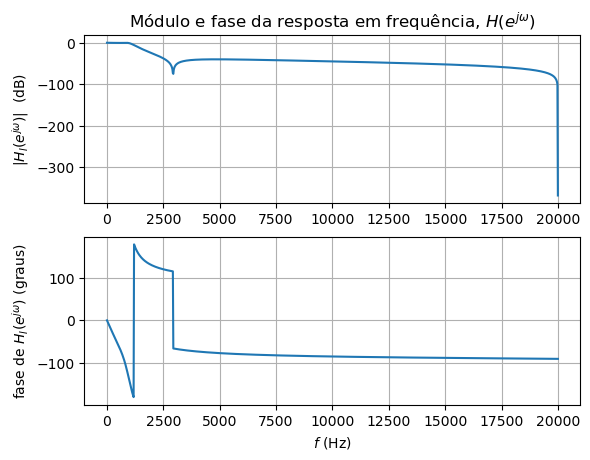

In [11]:
omega = range(0,pi,length=1000);

H_filtro = freqz(h_filtro, omega);



subplot(211)
plot(omega*fa/(2*pi),amp2db.(abs.(H_filtro)));
title(L"Módulo e fase da resposta em frequência, $H (e^{j\omega})$");
ylabel(L"$|H_I(e^{j\omega})|$  (dB)"); grid();

subplot(212)
plot(omega*fa/(2*pi),angle.(H_filtro)*180/pi)
ylabel(L"fase de $H_I(e^{j\omega})$ (graus)"); xlabel(L"$f$ (Hz)"); grid();

Pode-se verificar que o módulo da resposta em frequência do filtro respeita as especificações informadas no enunciado.

De fato, podemos constatar isso por meio de uma visualização aproximada ("zoom") das regiões de interesse (banda passante e banda de rejeição):

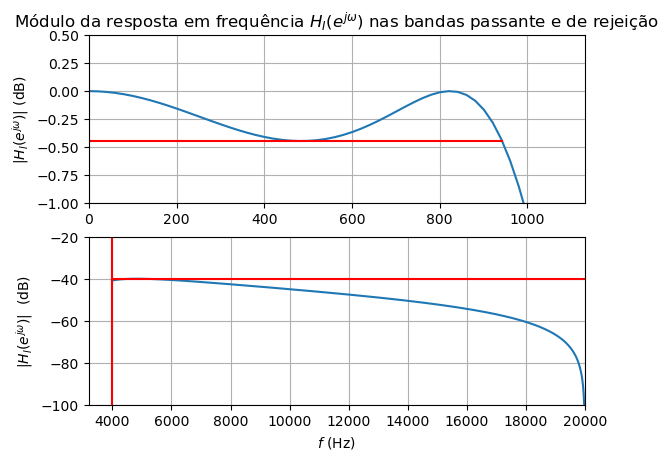

In [12]:
subplot(2,1,1);
title(L"Módulo da resposta em frequência $H_I(e^{j\omega})$ nas bandas passante e de rejeição");
plot((omega*fa/(2*pi))[1:100],(amp2db.(abs.(H_filtro)))[1:100]);
ylabel(L"$|H_I(e^{j\omega})|$ (dB)"); grid();

plot([0; omega_p*fa/(2*pi)],20*log10.([1-delta_p;1-delta_p]),"r");
#plot([0; omega_p*fa/(2*pi)],20*log10.([1;1]),"r");

axis([0, 1.2*omega_p*fa/(2*pi),-1,0.5]);

subplot(2,1,2);
plot((omega*fa/(2*pi))[200:end],(amp2db.(abs.(H_filtro)))[200:end]);
ylabel(L"$|H_I(e^{j\omega})|$  (dB)"); xlabel(L"$f$ (Hz)"); grid();
plot([omega_r*fa/(2*pi);fa/2],20*log10.([delta_r;delta_r]),"r");
plot([omega_r*fa/(2*pi);omega_r*fa/(2*pi)],[-100;-20],"r");

axis([0.8*omega_r*fa/(2*pi),fa/2,-100,-20]);

## Resolução do item 1)

Como calculado anteriormente, os coeficientes do filtro estão armazenados em ``b`` (coeficientes do numerador) e em ``a`` (coeficientes do denominador). Vamos, a seguir, quantizá-los com 12 bits:

In [13]:
Bc = 12;

bq = Fixed{Int16,Bc-1}.(b);
aq = Fixed{Int16,Bc-1}.(a);

Agora, vamos definir uma variável ``hq_filtro`` do tipo ``filter``, a partir dos **coeficientes quantizados**:

In [14]:
hq_filtro = PolynomialRatio(bq,aq);

Agora, obtemos a resposta em frequência do filtro com os coeficientes quantizados:

In [15]:
Hq_filtro = freqz(hq_filtro, omega);

**Denotemos por $\tilde H_I(z)$ o filtro obtido a partir do filtro original $H_I(z)$, quando quantizamos os coeficientes deste último.**

Plotamos, a seguir, a resposta em frequência do filtro projetado com coeficientes quantizados.

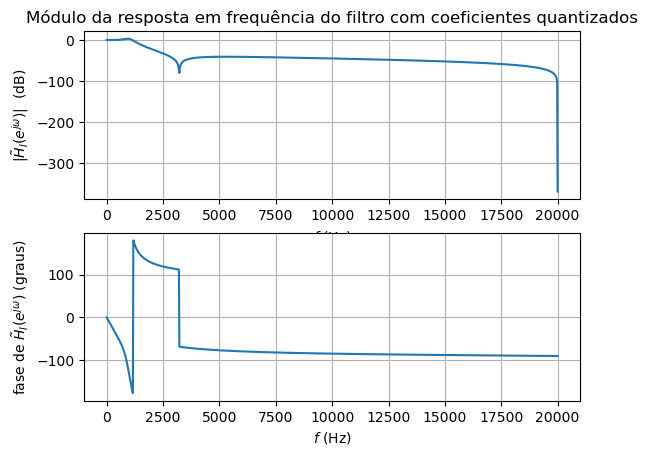

In [16]:
subplot(211)
plot(omega*fa/(2*pi),amp2db.(abs.(Hq_filtro)));
title("Módulo da resposta em frequência do filtro com coeficientes quantizados");
ylabel(L"$|\tildeH_I(e^{j\omega})|$  (dB)"); xlabel(L"$f$ (Hz)"); grid();

subplot(212)
plot(omega*fa/(2*pi),angle.(Hq_filtro)*180/pi)
ylabel(L"fase de $\tilde H_I(e^{j\omega})$ (graus)"); xlabel(L"$f$ (Hz)"); grid();

Vejamos, agora, se o filtro com coeficientes quantizados, $\tilde H_I(z)$, atende às especificações dadas no enunciado. Para tanto, vamos analisar uma visão aproximada ("zoom") do módulo da resposta em frequência nas bandas passante e de rejeição:

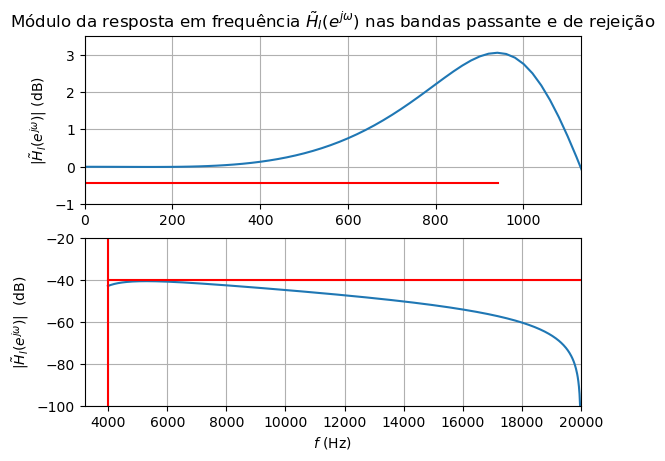

In [17]:
subplot(2,1,1);
title(L"Módulo da resposta em frequência $\tilde H_I(e^{j\omega})$ nas bandas passante e de rejeição");
plot((omega*fa/(2*pi))[1:100],(amp2db.(abs.(Hq_filtro)))[1:100]);
ylabel(L"$|\tilde H_I(e^{j\omega})|$ (dB)"); grid();

plot([0; omega_p*fa/(2*pi)],20*log10.([1-delta_p;1-delta_p]),"r");
#plot([0; omega_p*fa/(2*pi)],20*log10.([1;1]),"r");

axis([0, 1.2*omega_p*fa/(2*pi),-1,3.5]);

subplot(2,1,2);
plot((omega*fa/(2*pi))[200:end],(amp2db.(abs.(Hq_filtro)))[200:end]);
ylabel(L"$|\tilde H_I(e^{j\omega})|$  (dB)"); xlabel(L"$f$ (Hz)"); grid();
plot([omega_r*fa/(2*pi);fa/2],20*log10.([delta_r;delta_r]),"r");
plot([omega_r*fa/(2*pi);omega_r*fa/(2*pi)],[-100;-20],"r");

axis([0.8*omega_r*fa/(2*pi),fa/2,-100,-20]);

Vemos que o módulo da resposta em frequência do filtro com coeficientes quantizados ultrapassa o ganho  unitário em valor absoluto (o que equivale a ganho nulo em dB), na banda de passagem. De toda forma, nessa região, a queda máxima $\delta_p = 0,05$ é respeitada (dado que $20\cdot \log(1-\delta_p) = 0,445$ dB). Notamos que, no caso caso do filtro original (com coeficientes **não quantizados**), $H_I(z)$, o módulo da resposta em frequência não ultrapassa 0 dB na banda passante.

Na banda de rejeição, o filtro com coeficientes quantizados, $\tilde H_I(z)$, respeita a especificação de atenuação mínima (40 dB).

Para melhor comparação, plotamos, no mesmo gráfico, os módulos das respostas em frequência do filtro original e do filtro quantizado:

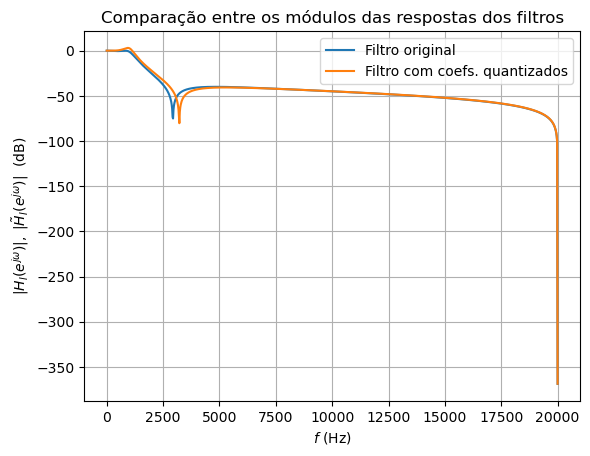

In [18]:
plot(omega*fa/(2*pi), amp2db.(abs.(H_filtro)), label="Filtro original");
plot(omega*fa/(2*pi), amp2db.(abs.(Hq_filtro)), label="Filtro com coefs. quantizados");
title("Comparação entre os módulos das respostas dos filtros");
ylabel(L"$|H_I(e^{j\omega})|, \; |\tilde H_I(e^{j\omega})|$  (dB)"); xlabel(L"$f$ (Hz)"); grid();
legend();

## Resolução do item 2)

Denotemos por $y_Q[n]$ a saída do filtro $\tilde H_I(e^{j\omega})$ quando em sua entrada aplicamos o sinal quantizado $s_q[n]$. Vamos considerar que o filtro é implementado com precisão infinita, mas utilizando coeficientes quantizados.

A entrada $s_q[n]$ pode ser decomposta em um sinal determinístico (correspondente ao sinal original $s[n]$) e um sinal aleatório (correspondente ao ruído de quantização $\varepsilon_0[n]$), isto é,

$$
s_q[n] = s[n] + \varepsilon_0[n]
$$

A saída $y_Q[n]$ do filtro pode ser decomposta em duas componentes: uma delas corresponde à saída $y_{Q, s}[n]$ do filtro quando em sua entrada aplica-se o sinal sem quantização $s[n]$; a outra componente é a saída $y_{Q,\varepsilon_0}[n]$ do filtro quando a entrada é o ruído de quantização $\varepsilon_0[n]$. Escrevemos, então,

$$
y_Q[n] = y_{Q,s}[n] + y_{Q,\varepsilon_0}[n]
$$

(Observação: a saída do filtro não é afetada por erro nas contas, uma vez que estamos assumindo que os cálculos são efetuados com precisão infinita).

Assim, o valor esperado da saída $y_Q[n]$ pode ser calculado como segue:

$$
m_{y_Q}[n] = \textrm{E}\{y_Q[n]\} = \textrm{E}\{ y_{Q,s}[n] + y_{Q,\varepsilon_0}[n] \}
$$

isto é,

$$
m_{y_Q}[n] = 
\textrm{E}\{y_{Q,s}[n]\} + \textrm{E}\{y_{Q,\varepsilon_0}[n]\}
$$

Considerando que o sinal $y_{Q,s}[n]$ é determinístico (pois é a resposta do filtro à entrada determinística $s[n]$) e que o filtro $\tilde H_I(z)$ é linear, resulta que

$$
\textrm{E}\{y_{Q,s}[n]\} = \tilde H_I(e^{j0})\cdot\textrm{E}\{s[n]\}
= \tilde H_I(e^{j0})\cdot s[n]
$$

Por outro lado, como o ruído de quantização $\varepsilon_0$ do sinal de entrada é estacionário no sentido amplo (pois é estacionário no sentido estrito, uma vez que é i.i.d.), resulta

$$
\textrm{E}\{y_{Q,\varepsilon_0}[n]\} = \tilde H_I(e^{j0})\cdot\textrm{E}\{\varepsilon_0[n]\} = \tilde H_I(e^{j0})\cdot (0) = 0
$$

para todo $n$, uma vez que $\textrm{E}\{\varepsilon_0[n]\} \equiv 0$. De fato, como discutido anteriormente, o ruído de quantização é tal que $\varepsilon_0[n] \sim \textrm{Uniforme}(-2^{-5}, 2^{-5})$.

Substituindo os últimos resultados na expressão apresentada para $m_{y_Q}[n]$, resulta que a função valor esperado de $y_Q[n]$ é dada por
$m_{y_Q}[n] = \tilde H_I(e^{j0})\cdot s[n] + 0$,
isto é,

$$
m_{y_Q}[n] = \tilde H_I(e^{j0})\cdot s[n]
$$

Escrevendo a função de transferência do filtro na forma

$$
\tilde H_I(z) = \frac{\sum_{i=0}^{M}\tilde b_i\cdot z^{-i}}{1+\sum_{j=1}^{N}\tilde a_i\cdot z^{-j}}
$$

(em que os $\tilde b_i$ e $\tilde a_j$ são os coeficientes do filtro original após serem quantizados) resulta que

$$
\tilde H_I(e^{j0}) = \frac{\sum_{i=0}^{M} \tilde b_i}{1+\sum_{j=1}^{N} \tilde a_i}
$$

Logo:

$$
m_{y_Q}[n] = \Big(\frac{\sum_{i=0}^{M} \tilde b_i}{1+\sum_{j=1}^{N} \tilde a_i}\Big)\cdot s[n]
$$

Abaixo, calculamos a soma dos coeficientes do numerador de $\tilde H_I(z)$, bem como a soma dos coeficientes do denominador. Além disso, calculamos a resposta em frequência calculada em $\omega = 0$.

In [19]:
print("Soma dos coeficientes do numerador:   ", sum(bq), "\n", 
      "Soma dos coeficientes do denominador: ", sum(aq))
print("\n\nResposta em frequência calculada em omega = 0: ", sum(bq)/sum(aq))

Soma dos coeficientes do numerador:   0.0029296875
Soma dos coeficientes do denominador: 0.0029296875

Resposta em frequência calculada em omega = 0: 1.0

De fato, como esperado (e verificado no gráfico referente ao módulo da resposta em frequência do filtro), temos $\tilde H_I(e^{j0}) = 1$.

Portanto, 

$$
m_{y_Q}[n] = \tilde H_I(e^{j0}) \cdot s[n]
= (1) \cdot s[n]
$$

ou seja, $m_{y_Q}[n] = s[n]$ para todo $n$.

## Resolução do item 3)

Denotemos por $y[n]$ a resposta do filtro com a entrada "limpa", isto é, sem quantização de $s[n]$. Vamos definir o erro $\varepsilon_Q[n] = y_Q[n] - y[n]$.

Vamos denotar por $\tilde h[n]$ a resposta ao impulso do filtro empregado (cujos coeficientes foram obtidos pela quantização dos coeficientes do filtro original $H_I(z)$).

Temos:

$$
y_Q[n] = \tilde h[n] * s_q[n] = \tilde h[n] * (s[n] + \varepsilon_0[n])
= \tilde h[n] * s[n] + \tilde h[n] * \varepsilon_0[n]
$$

e

$$
y[n] = \tilde h[n] * s[n]
$$

Logo,

$$
\varepsilon_Q[n] = y_Q[n] - y[n] = \tilde h[n] * \varepsilon_0[n]
$$

que corresponde à saída obtida pela passagem do processo estocástico $\varepsilon_0[n]$ pelo filtro $\tilde H(z)$.

**Como $\varepsilon_0[n]$ é um processo estacionário em sentido amplo (WSS) e o filtro é linear, resulta que o sinal $\varepsilon_Q[n]$ também é estacionário em sentido amplo**, como visto na teoria (_páginas 58 a 60 da apostila da disciplina_).

O valor DC de $\varepsilon_Q[n]$ corresponde a seu valor esperado $\textrm{E}\{\varepsilon_Q[n]\}$. Como tal processo é WSS, seu valor esperado é constante, e dado por

$$
\textrm{E}\{\varepsilon_Q[n]\} = \mu_{\varepsilon_Q} 
=  \tilde H_I(e^{j0}) \cdot \mu_{\varepsilon_0} = \tilde H_I(e^{j0}) \cdot (0)
= 0
$$

em que $\mu_{\varepsilon_0} = 0$ é o valor esperado do ruído de quantização $\varepsilon_0[n]$ do sinal de entrada. **Logo, o valor DC do erro $\varepsilon_Q[n]$ é nulo**.

Como vimos anteriormente, o processo $\varepsilon_0[n]$ é ergódico (na correlação), pois é i.i.d. e tem variância finita. Como $\varepsilon_Q = \tilde h[n] * \varepsilon_0[n]$, podemos então calcular sua potência média $P_{\varepsilon_Q}$ da seguinte maneira (_conforme página 60 da apostila do curso_):

$$
P_{\varepsilon_Q} = r_{\varepsilon_Q}[0] = \tilde h[0] * \tilde h[0] * r_{\varepsilon_0}[0]
$$

isto é:

$$
P_{\varepsilon_Q} = \Big( \sum_{n=-\infty}^{+\infty} (\tilde h[n])^2 \Big) \cdot r_{\varepsilon_0}[0]
= \Big( \sum_{n=-\infty}^{+\infty} (\tilde h[n])^2 \Big) \cdot\textrm{var}\{\varepsilon_0[n]\}
= \Big( \sum_{n=-\infty}^{+\infty} (\tilde h[n])^2 \Big) \cdot P_{\varepsilon_0}
$$

pois $r_{\varepsilon_0}[n] = \textrm{var}\{\varepsilon_0[n]\}\cdot\delta[n] = P_{\varepsilon_0}\cdot\delta[n]$ (lembrando que $P_{\varepsilon_0}$ é a potência média do ruído de entrada $\varepsilon_0[n]$).


_Observação 1:_

A resposta ao impulso do filtro $\tilde H_I(z)$ pode ser expressa como

$$
\tilde h[n] = - \tilde a_1 \cdot \tilde h[n-1] - \tilde a_2 \cdot \tilde h[n-2] - ... - \tilde a_N \cdot \tilde  h[n-N]
+ \tilde b_0 \cdot \delta[n] + \tilde b_1 \cdot \delta[n-1] + ... + \tilde b_M \cdot \delta[n-M]
$$

Assim, temos:

$$\tilde h[n] = 0 \; \textrm{se} \; n < 0 \quad \textrm{(pois filtro é causal)}$$

$$\tilde h[0] = \tilde b_0$$

$$\tilde h[1] = - \tilde a_1 \cdot \tilde h[0] + \tilde b_1$$

$$\tilde h[2] = - \tilde a_2 \cdot \tilde h[0] - \tilde a_1 \cdot \tilde h[1]  + \tilde b_1 + \tilde b_2$$

$$\tilde h[3] = -\tilde a_3\cdot\tilde h[0]-\tilde a_2\cdot\tilde h[1]-\tilde a_1\cdot h[2]+\tilde b_1 + \tilde b_2 + \tilde b_3$$

e assim por diante. Considerando que a resposta ao impulso decaia a zero para valores elevados de $n$, podemos estimar a soma $\sum_{n=-\infty}^{\infty} (\tilde h[n])^2 = \sum_{n=0}^{\infty} (\tilde h[n])^2$ por meio da soma de um número suficientemente grande de termos.

_(Fim da Observação 1)_

Estimaremos, a seguir, a potência

$$
P_{\varepsilon_Q}
= \Big( \sum_{n=-\infty}^{+\infty} (\tilde h[n])^2 \Big) \cdot P_{\varepsilon_0}
= \Big( \sum_{n=0}^{\infty} (\tilde h[n])^2 \Big) \cdot P_{\varepsilon_0}
$$

(Na soma entre parênteses, usaremos $n$ variando até 1000). Temos:

In [20]:
resp_imp_hq = impz(hq_filtro, 1000);
pot_ruido_quant_saida = sum(resp_imp_hq.^2) * pot_ruido_quant

2.6439836044513715e-5

_Observação 2:_

Aplicando o Teorema de Parseval, podemos escrever, também:

$$
P_{\varepsilon_Q} = \Big( \frac{1}{2\pi} \int_{0}^{2\pi} |\tilde H_I(e^{j\omega})|^2 \, d\omega \Big) \cdot P_{\varepsilon_0}
$$

ou, substituindo a expressão de $P_{\varepsilon_0}$,

$$
P_{\varepsilon_Q} = \Big( \frac{1}{2\pi} \int_{0}^{2\pi} |\tilde H_I(e^{j\omega})|^2 \, d\omega \Big) \cdot \frac{(2\cdot 2^{-5})^2}{12} \approx \Big( \frac{1}{2\pi} \int_{0}^{2\pi} |\tilde H_I(e^{j\omega})|^2 \, d\omega \Big) \cdot 3,2552 \cdot 10^{-4}
$$

_(Fim da Observação 2)_

<br />

Assim, podemos fazer uma verificação do valor obtido para a potência do ruído $\varepsilon_Q[n]$, calculando a integral de $|\tilde H(e^{j\omega})|^2$ de $\omega = 0$ até $\omega = 2\pi$. Vamos utilizar a biblioteca ``NumericalIntegration``. Levaremos em conta que $\tilde H(e^{j\omega})$ é simétrica.

Assim, estimamos a potência média $\varepsilon_Q[n]$ da seguinte forma, e verificamos que o valor é compatível ao encontrado pelo outro método (em que somamos os elementos ao quadrado da resposta ao impulso):

In [21]:
using NumericalIntegration

2 * (integrate(omega,(abs.(Hq_filtro)).^2))/(2*pi) * (2*2^(-5))^2 / 12

2.6343542150261945e-5

_Observação 3:_

No caso **teórico**, em que o filtro passa-baixas é **ideal**, a potência média de $\varepsilon_Q[n]$ pode ser calculada como

$$
P_{\varepsilon_Q} \textrm{(caso ideal)}
= \Big( \frac{1}{2\pi}\int_{0}^{\omega_p} (1)^2 \; d\omega \Big) \cdot P_{\varepsilon_0} = \frac{\omega_p}{2\pi} \cdot P_{\varepsilon_0}
$$

Tomando $\omega_p$ como a maior frequência dentre os componentes do sinal $s[n]$ (isto é, 
$\omega_p = (6 \pi \cdot f_0)/f_a \approx 0,1480 \; \textrm{rad/amostra}$), resulta

$$
P_{\varepsilon_Q} \textrm{(caso ideal)} \approx \frac{0,1480}{2\pi} \cdot 3,2552 \cdot 10^{-4}
\approx 7,67 \cdot 10^{-6}
$$

Nesse caso, devemos notar que a potência do ruído é inferior ao caso em que o filtro é não ideal (e, além disso, com coeficientes quantizados). De fato, era de se esperar que um filtro passa-baixas **ideal** reduzisse mais intensamente a potência do ruído na saída.

_(Fim da Observação 3)_

<br />

Vamos, agora, obter o sinal $\varepsilon_Q[n] = y_Q[n] - y[n]$ . Denotaremos tal sinal por ``ruido_quant_saida``:

In [22]:
yQ = filt(hq_filtro,sq);
y = filt(hq_filtro,s);

ruido_quant_saida = yQ-y;

A potência calculada "**experimentalmente**" de $\varepsilon_Q[n]$ é calculada a seguir:

In [23]:
pot_ruido_quant_saida = sum(ruido_quant_saida.^2)/length(ruido_quant_saida)

0.0006724646219878865

<hr style="border:2px solid black">


## <span style="color:red">Observação</span> (sobre um "problema" para o qual ainda não encontrei explicação):

Na célula acima, calculei "experimentalmente" a potência do sinal $y_Q[n] - y[n]$. Notei que tal valor (0,000672) ficou diferente ao cálculo teórico que fiz de $P_{\varepsilon_Q}$ (que resultou em $2,64\cdot 10^{-5}$), por algum motivo que ainda não compreendi.

Anteriormente, defini $\varepsilon_0 = s_q[n] - s[n]$.

Por algum motivo que ainda estou tentando entender, estou obtendo sinais diferentes, quando calculo a saída do filtro $\tilde H_I(z)$ para entrada igual a $\varepsilon_0[n] = s_q[n] - s[n]$, e quando calculo a diferença $y_Q[n] - y[n]$. 

Teoricamente, como o filtro é a princípio linear, os sinais 

$$
\tilde h[n] * \varepsilon_0[n] = \tilde h[n] * (s_q[n] - s[n])
$$ 

e 

$$
y_Q[n] - y[n] = (\tilde h[n] * s_q[n]) - (\tilde h[n] * s[n]) 
$$

deveriam ser iguais para todo $n$. No entanto, isso não está ocorrendo, como podemos ver abaixo, em que faço o cálculo ponto-a-ponto da diferença 
``filt(hq_filtro,sq-s) - ( filt(hq_filtro,sq) - filt(hq_filtro,s) )``:

In [24]:
filt(hq_filtro,sq-s) - ( filt(hq_filtro,sq) - filt(hq_filtro,s) )

120001-element Vector{Float64}:
 -2.168404344971009e-19
 -2.7418136596682127e-6
  0.0001402186462655652
 -1.4103714306664718e-5
 -0.00043421642556074915
 -0.0008468775601617598
 -0.0014947276688678265
 -0.002591439002496046
 -0.003773079041868575
 -0.005011817165187509
 -0.006323841784988423
 -0.0075204092637194166
 -0.009104772677177492
  ⋮
 -0.012472252720012457
 -0.01476449812116828
 -0.016587350898898907
 -0.018169982923739468
 -0.01914169199871401
 -0.019761772309192016
 -0.01975427822170886
 -0.019006787589673935
 -0.017741705415568666
 -0.015807121838888646
 -0.012990117157971614
 -0.009728512675413874

Por outro lado, com o filtro original $H_I(z)$ (cujos coeficientes não estão quantizados), os sinais

$$
h[n] * \varepsilon_0[n] = [n] * (s_q[n] - s[n])
$$ 

e 

$$
y_Q[n] - y[n] = (h[n] * s_q[n]) - (h[n] * s[n]) 
$$

são de fato iguais, como mostrado abaixo (em que a diferença ponto-a-ponto é, na prática, aproximadamente nula):

In [25]:
filt(h_filtro,sq-s) - ( filt(h_filtro,sq) - filt(h_filtro,s) )

120001-element Vector{Float64}:
 -6.776263578034403e-20
 -2.981555974335137e-19
  5.5294310796760726e-18
  7.182839392716467e-18
 -8.158621347953421e-18
 -2.3744027577432547e-17
 -4.754226526348937e-17
 -3.973600962159374e-17
 -5.095750210681871e-17
 -6.784395094328044e-17
 -5.3613797429408194e-17
 -1.2682454912649188e-16
 -6.220609964635582e-17
  ⋮
  3.2395960913866872e-16
  1.2815269678778662e-16
 -5.1093027378379396e-17
 -2.312603233911581e-16
 -4.412702842016003e-16
 -6.158268339717665e-16
 -7.710845850716908e-16
 -9.298117831235686e-16
 -1.0299920638612292e-15
 -1.0837684916165102e-15
 -1.1319070680748666e-15
 -1.1041514924592377e-15

Se calculo a potência média da saída do filtro $\tilde H_I(z)$, quando a entrada é $\varepsilon_0[n]$, o valor obtido é de fato compatível com o cálculo teórico de $P_{\varepsilon_Q}$ realizado anteriormente:

In [26]:
sum((filt(hq_filtro,ruido_quant)).^2)/length(ruido_quant)

# Obs: poderíamos usar: var(filt(hq_filtro, ruido_quant))

2.733723356516534e-5

Acredito que o "problema" mencionado esteja relacionado a alguma dificuldade que a função ``filt`` possa ter para lidar com sinais cujos valores estão no formato de ponto fixo.

<br />

Notei que, se eu definir ``sq = float.(Fixed{Int16,4}.(s))``, ou seja, se converter os valores do sinal $s_q[n]$ para tipo ``float``, após estes terem sido convertidos inicialmente para valores representáveis em 5 bits, então a diferença

``filt(hq_filtro,sq-s) - ( filt(hq_filtro,sq) - filt(hq_filtro,s) )``

fica mais próxima de 0 para todo $n$. Ou seja, de fato, passamos a verificar que os sinais

$$
\tilde h[n] * \varepsilon_0[n] = \tilde h[n] * (s_q[n] - s[n])
$$ 

e 

$$
y_Q[n] - y[n] = (\tilde h[n] * s_q[n]) - (\tilde h[n] * s[n]) 
$$

ficam compatíveis (isto é, na prática, ficam "iguais"), como esperado.

Por conta disso, no que segue, adotarei ``sq = float.(Fixed{Int16,4}.(s))``.

In [27]:
# Obtemos novamente o sinal sq, mas dessa vez convertendo seus valores 
# para o tipo float, após estes terem sido convertidos para valores 
# representáveis com 5 bits

sq = float.(Fixed{Int16,4}.(s));

Assim, notamos que, ao recalcular a potência de $\varepsilon_Q[n] = y_Q[n] - y[n]$, o valor obtido "experimentalmente" se aproxima do valor calculado na teoria (aproximadamente $2,64\cdot 10^{-5}$):

In [28]:
yQ = filt(hq_filtro,sq);
y = filt(hq_filtro,s);

ruido_quant_saida = yQ-y;

pot_ruido_quant_saida = sum(ruido_quant_saida.^2)/length(ruido_quant_saida);

print("Potência média na saída correspondente ao ruído de quantização: \n", 
    pot_ruido_quant_saida)

Potência média na saída correspondente ao ruído de quantização: 
2.7337816482205935e-5

<hr style="border:2px solid black">

Agora, calculamos "experimentalmente" a potência média da saída $y[n]$ do filtro (considerando a entrada não quantizada $s[n]$):

In [29]:
pot_y = sum(y.^2)/length(y)

0.20247301586156186

Portanto, a **relação sinal-ruído na saída, em dB**, é igual a:

In [30]:
10*log10(pot_y/pot_ruido_quant_saida)

38.69603328001525

## Resolução do item 4)

**No item anterior, (3), já obtivemos a saída $y_Q[n]$ do filtro, quando a entrada é $s_q[n]$. Já calculamos, também, a potência média do ruído na saída do filtro (de forma teórica e experimental), utilizando o conceito de ergodicidade.**

(_Ver **<span style="color:red">Observação</span>** feita anteriormente._)

<br />

## Resolução do item 5)

 Vamos, agora, gerar os sinais de saída considerando que o filtro $\tilde H_I(z)$ seja implementado usando aritmética de precisão finita com 12 bits para os cálculos. Vamos assumir que os cálculos intermediários usem registrador de precisão dupla. 

In [31]:
include("fxfilt.jl")

fxfilt

Inicialmente, calculemos a saída do filtro quando a entrada é o sinal "limpo" $s[n]$, e plotamos seu gráfico (para $0 \leq n \leq 1000$):

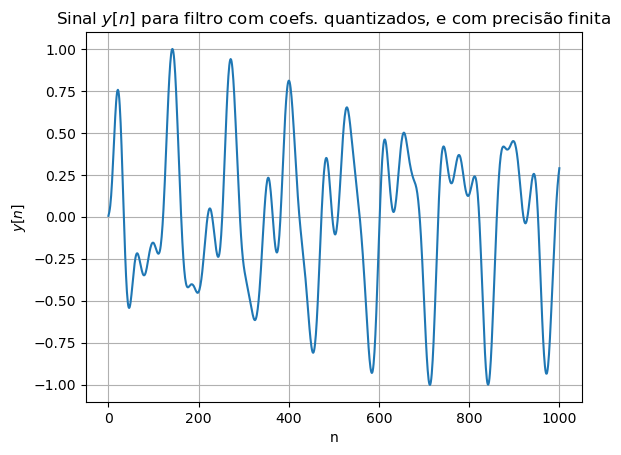

In [32]:
y_comPrecFinita =  fxfilt(bq,aq,Fixed{Int16,11}.(s),true);

plot(y_comPrecFinita[1:1001]);
title(L"Sinal $y[n]$ para filtro com coefs. quantizados, e com precisão finita");
ylabel(L"y[n]"); xlabel("n"); grid();

Calculemos, agora, a saída do filtro quando a entrada é o sinal quantizado $s_q[n]$, e plotemos seu gráfico (para $0 \leq n \leq 1000$):

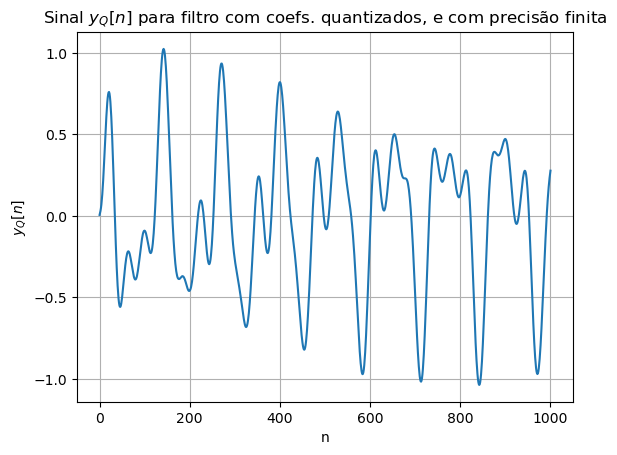

In [33]:
yQ_comPrecFinita =  fxfilt(bq,aq,Fixed{Int16,11}.(sq),true);

plot(yQ_comPrecFinita[1:1001]);
title(L"Sinal $y_Q[n]$ para filtro com coefs. quantizados, e com precisão finita");
ylabel(L"y_Q[n]"); xlabel("n"); grid();

Podemos plotar a diferença entre tais sinais, para $0 \leq n \leq 1000$:

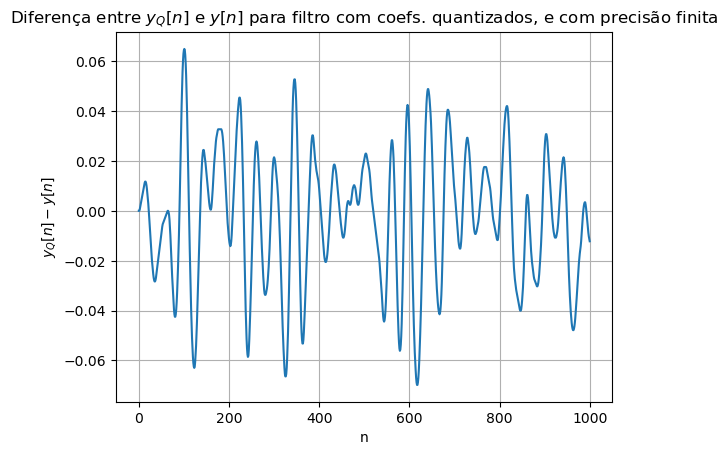

In [34]:
plot(yQ_comPrecFinita[1:1001]-y_comPrecFinita[1:1001]);

title(L"Diferença entre $y_Q[n]$ e $y[n]$ para filtro com coefs. quantizados, e com precisão finita");
ylabel(L"y_Q[n] - y[n]"); xlabel("n"); grid();

## Resolução do item 6)

O ruído total de saída, $\varepsilon_T[n]$, neste caso, é dado pela diferença entre a saída para entrada quantizada $s_q[n]$ e supondo precisão finita (em 12 bits), e a saída para entrada não quantizada $s[n]$ e supondo precisão infinita.

Vamos obter o sinal $\varepsilon_T[n]$, que denotaremos por ``ruido_total_saida``:

In [35]:
ruido_total_saida = yQ_comPrecFinita - y;

Como $\varepsilon_T[n]$ pode ser suposto ergódico, podemos calcular sua potência média por meio de sua variância:

$$
P_{\varepsilon_T} = \textrm{var}\{\varepsilon_T[n]\}
$$

Assim, obtemos o seguinte valor para a potência média do ruído $\varepsilon_T[n]$:

In [36]:
pot_ruido_total_saida = var(ruido_total_saida)

0.0002830033985418451

Como já vimos, a potência média do sinal de saída $y[n]$ é dado por:

In [37]:
pot_y = sum(y.^2)/length(y)

0.20247301586156186

Logo, a SNR de saída, em dB, é igual a:

In [38]:
10*log10(pot_y/pot_ruido_total_saida)

28.54575500853789

## Resolução do item 7)

Item não resolvido.

## Resolução do item 8)

**Consideração do ruído de quantização do sinal de entrada:**

Como vimos, o ruído de quantização da entrada é $\varepsilon_0[n] \sim \textrm{Uniforme}(-2^{-5}, 2^{-5})$, e é i.i.d.

Além disso, como já calculado, a potência média de tal ruído é

$$
P_{\varepsilon_0} = \frac{(2\cdot2^{-5})^2}{12} \approx 3,2552 \cdot 10^{-4}
$$

A potência do ruído $y_{\varepsilon_0}$ na saída, correspondente à passagem de $\varepsilon_0[n]$ pelo filtro $\tilde H_I(z)$ é calculada como

$$
P_{y_{\varepsilon_0}}
= \Big( \sum_{n=-\infty}^{+\infty} (\tilde h[n])^2 \Big) \cdot P_{\varepsilon_0}
\approx 2,644 \cdot 10^{-5}
$$

como obtido no item 3.

**Consideração do ruído interno devido a erro nas contas com precisão finita:**

_**Observação:**_ Vamos assumir que as contas intermediárias são efetuadas com precisão simples.

Sendo a função de transferência dada por

$$
\tilde H_I(z) = \frac{\sum_{i=0}^{M}\tilde b_i\cdot z^{-i}}{1+\sum_{j=1}^{N}\tilde a_i\cdot z^{-j}}
$$

e seguindo o procedimento apresentado nas Notas de Aula da disciplina (2021), podemos expressar o ruído interno $\varepsilon_1[n]$ devido ao erro nas contas como a soma de $M + N + 1$ erros i.i.d. com distribuição uniforme no intervalo $(-2^{-12}, 2^{-12})$. No presente caso, temos M = N = 3.

Sendo assim, a potência média do ruído interno $\varepsilon_1[n]$ é dada por 

$$
P_{\varepsilon_1} = (3+3+1) \cdot \frac{(2\cdot2^{-12})^2}{12}
\approx 1,390775 \cdot 10^{-7}
$$

O ruído $\varepsilon_1[n]$ afeta a saída por meio da sua passagem pela "segunda metade" do filtro (na implementação direta), que corresponde à função de transferência

$$
\tilde G(z) = \frac{1}{1+\sum_{j=1}^{N}\tilde a_i\cdot z^{-j}}
$$

Seja $\tilde g[n]$ a resposta ao impulso correspondente à $\tilde G(z)$. Então, resulta que a potência do ruído $y_{\varepsilon_1}$ na saída do filtro, devido à passagem de $\varepsilon_1[n]$ por $\tilde G(z)$, é calculada como

$$
P_{y_{\varepsilon_1}}
= \Big( \sum_{n=-\infty}^{+\infty} (\tilde g[n])^2 \Big) \cdot P_{\varepsilon_1}
$$

Calculemos, a seguir, uma aproximação para a soma $\sum_{n=-\infty}^{+\infty} (\tilde g[n])^2$:

In [39]:
sum( (impz(PolynomialRatio([1],aq), 1000)).^2 )

10838.50610709043

Logo, 

$$
P_{y_{\varepsilon_1}}
= \Big( \sum_{n=-\infty}^{+\infty} (\tilde g[n])^2 \Big) \cdot P_{\varepsilon_1}
\approx (10838,5061) \cdot (1,390775 \cdot 10^{-7})
$$

isto é: $P_{y_{\varepsilon_1}}\approx 1,50739 \cdot 10^{-3}$

Assim, supondo contas intermediárias com precisão simples, a potência total do ruído na saída do filtro é

$$
P_{y_{\varepsilon_0}} + P_{y_{\varepsilon_1}}
\approx 2,644 \cdot 10^{-5} + 1,50739 \cdot 10^{-3}
\approx 1,5338 \cdot 10^{-3}
$$

como calculado na célula abaixo:

In [40]:
pot_ruido_total_item8 = 
2.6439836044513715 * 10^(-5) + sum( (impz(PolynomialRatio([1],aq), 1000)).^2 ) * 7 * (2^(-24)/3)

0.0015338322176655765

A potência na saída correspondente à aplicação do sinal "limpo" $s[n]$ na entrada do filtro é $P_y$, que, como calculado no item 3, vale

$$
P_y \approx 0,20247
$$

Tal potência considera implementação dos cálculos com precisão infinita. Deve-se proceder assim, pois o efeito da precisão finita nas contas está incorporado na saída $y_{\varepsilon_1}$.

Calculemos, então, a relação sinal-ruído na saída, em dB:

In [41]:
10*log10(pot_y/pot_ruido_total_item8)

21.205892960322274